# Clustering Analysis - Resume Segmentation

**Objective**: Group resumes into meaningful clusters using unsupervised learning

## Goals:
1. Implement K-means clustering
2. Determine optimal number of clusters
3. Implement hierarchical clustering for comparison
4. Validate clusters using metrics
5. Characterize and name clusters
6. Visualize clusters using dimensionality reduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Clustering libraries
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

import joblib
import json

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Load Feature-Engineered Data

In [2]:
# Load processed data with features
df = pd.read_csv('../data/processed/resumes_with_features.csv')

print(f"✓ Loaded data: {df.shape}")
print(f"  Records: {len(df)}")
print(f"  Features: {len(df.columns)}")

df.head()

✓ Loaded data: (495, 55)
  Records: 495
  Features: 55


,ID,Category,Resume,Experience_Years,Education_Level,Skills,Num_Skills,Has_Certification,Num_Companies,Resume_str,...,Category_Database Administration,Category_DevOps,Category_Machine Learning,Category_Mobile Development,Category_Network Engineering,Category_Software Engineering,Category_UI/UX Design,Category_Web Development,Has_Certification_Encoded,Has_Leadership_Encoded
0,SYN_0001,Web Development,Full Stack Developer with 3 years of experienc...,-0.491615,Bachelor's,"Node.js, CSS, JavaScript, Redux, Vue.js, Expre...",0.192366,False,-0.627279,Unknown,...,False,False,False,False,False,False,False,True,-0.858395,-0.879883
1,SYN_0002,Web Development,Full Stack Developer with 9 years of experienc...,1.870999,Bachelor's,"Node.js, REST APIs, MySQL, Vue.js, PostgreSQL,...",1.445273,False,2.624062,Unknown,...,False,False,False,False,False,False,False,True,-0.858395,1.136515
2,SYN_0003,Software Engineering,Software Engineer with 6 years of experience. ...,0.689692,Master's,"Go, Programming, SQL, JavaScript, Algorithms, ...",0.505593,False,0.998392,Unknown,...,False,False,False,False,False,True,False,False,-0.858395,1.136515
3,SYN_0004,Web Development,Full Stack Developer with 5 years of experienc...,0.295923,Master's,"Node.js, CSS, Angular, JavaScript, MySQL, Vue....",1.132046,True,-0.627279,Unknown,...,False,False,False,False,False,False,False,True,1.164965,1.136515
4,SYN_0005,Network Engineering,Network Engineer with 2 years of experience. S...,-0.885384,Bachelor's,"Networking, Load Balancer, TCP/IP, Security, W...",-1.373769,False,-0.627279,Unknown,...,False,False,False,False,True,False,False,False,-0.858395,-0.879883


In [3]:
# Load feature list
with open('../models/ml_features.json', 'r') as f:
    ml_features = json.load(f)

print(f"\n✓ Loaded {len(ml_features)} ML features")
print(f"\nFeatures for clustering:")
for i, feat in enumerate(ml_features[:10], 1):
    print(f"  {i}. {feat}")
if len(ml_features) > 10:
    print(f"  ... and {len(ml_features) - 10} more")


✓ Loaded 33 ML features

Features for clustering:
  1. Num_Skills
  2. Resume_Length
  3. Resume_Word_Count
  4. Experience_Years
  5. Experience_Level_Encoded
  6. Education_Level_Encoded
  7. Skill_Diversity
  8. Technical_Skills_Count
  9. Technical_Ratio
  10. Has_Certification_Encoded
  ... and 23 more


## 2. Prepare Data for Clustering

In [4]:
# Select features for clustering
# Focus on skill-related and experience features
clustering_features = [
    'Num_Skills',
    'Experience_Years',
    'Experience_Level_Encoded',
    'Education_Level_Encoded',
    'Skill_Diversity',
    'Technical_Skills_Count',
    'Technical_Ratio',
    'Has_Certification_Encoded',
    'Has_Leadership_Encoded'
]

# Add skill category counts if available
skill_cat_features = [col for col in df.columns if col.startswith('Num_') and 
                      col not in clustering_features and col != 'Num_Companies']
clustering_features.extend([f for f in skill_cat_features if f in df.columns])

# Filter to existing columns
clustering_features = [f for f in clustering_features if f in df.columns]

print(f"Using {len(clustering_features)} features for clustering:")
print(clustering_features)

Using 20 features for clustering:
['Num_Skills', 'Experience_Years', 'Experience_Level_Encoded', 'Education_Level_Encoded', 'Skill_Diversity', 'Technical_Skills_Count', 'Technical_Ratio', 'Has_Certification_Encoded', 'Has_Leadership_Encoded', 'Num_Skills_is_outlier', 'Num_Companies_is_outlier', 'Num_programming_languages', 'Num_web_technologies', 'Num_databases', 'Num_data_science', 'Num_cloud_devops', 'Num_mobile', 'Num_design', 'Num_soft_skills', 'Num_other_technical']


In [5]:
# Prepare clustering data
X = df[clustering_features].copy()

# Handle any missing values
X = X.fillna(X.median())

print(f"\n✓ Clustering data prepared")
print(f"  Shape: {X.shape}")
print(f"  Missing values: {X.isnull().sum().sum()}")

# Show summary statistics
print(f"\nFeature statistics:")
X.describe()


✓ Clustering data prepared
  Shape: (495, 20)
  Missing values: 0

Feature statistics:


,Num_Skills,Experience_Years,Experience_Level_Encoded,Education_Level_Encoded,Skill_Diversity,Technical_Skills_Count,Technical_Ratio,Has_Certification_Encoded,Has_Leadership_Encoded,Num_programming_languages,Num_web_technologies,Num_databases,Num_data_science,Num_cloud_devops,Num_mobile,Num_design,Num_soft_skills,Num_other_technical
count,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02
mean,1.184238e-16,1.507212e-16,1.722528e-16,-4.019232e-16,9.689219e-17,1.884015e-17,-7.177199e-17,-9.330359e-17,9.330359e-17,-7.894919e-17,-3.588600e-17,9.330359e-17,4.306320e-17,-5.382900e-17,8.612639e-17,-3.409170e-17,2.870880e-17,-1.076580e-16
std,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00
min,-2.000223e+00,-1.279152e+00,-1.177706e+00,-8.268455e-01,-1.862048e+00,-1.300317e+00,-1.499249e+00,-8.583951e-01,-8.798827e-01,-7.657451e-01,-3.553243e-01,-5.567940e-01,-5.026506e-01,-5.459169e-01,-2.896360e-01,-3.109851e-01,-1.507557e-01,-7.383501e-01
25%,-7.473151e-01,-8.853835e-01,-1.177706e+00,-8.268455e-01,-1.084230e+00,-1.032015e+00,-1.197327e+00,-8.583951e-01,-8.798827e-01,-7.657451e-01,-3.553243e-01,-5.567940e-01,-5.026506e-01,-5.459169e-01,-2.896360e-01,-3.109851e-01,-1.507557e-01,-7.383501e-01
50%,1.923656e-01,-9.784562e-02,-8.190814e-02,-8.268455e-01,-3.064129e-01,4.119387e-02,6.142078e-01,-8.583951e-01,-8.798827e-01,-7.657451e-01,-3.553243e-01,-5.567940e-01,-5.026506e-01,-1.236843e-01,-2.896360e-01,-3.109851e-01,-1.507557e-01,-7.383501e-01
75%,8.188194e-01,6.896923e-01,1.013890e+00,1.209416e+00,4.714045e-01,8.461004e-01,8.783900e-01,1.164965e+00,1.136515e+00,3.898763e-01,-3.553243e-01,-2.980924e-02,-5.026506e-01,-1.236843e-01,-2.896360e-01,-3.109851e-01,-1.507557e-01,2.036172e-01
max,2.698181e+00,2.264768e+00,2.109688e+00,1.209416e+00,2.804857e+00,2.455913e+00,1.036899e+00,1.164965e+00,1.136515e+00,3.856740e+00,4.308308e+00,3.659084e+00,3.360891e+00,4.520875e+00,5.354844e+00,4.516327e+00,6.633250e+00,3.971486e+00


## 3. Determine Optimal Number of Clusters (K)

We'll use two methods:
1. **Elbow Method**: Find the "elbow" in inertia plot
2. **Silhouette Score**: Higher is better (range: -1 to 1)

In [6]:
# Test different numbers of clusters
K_range = range(2, 11)
inertias = []
silhouette_scores = []

print("Testing different numbers of clusters...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X, labels)
    silhouette_scores.append(sil_score)
    
    print(f"  K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")

print("\n✓ Analysis complete")

Testing different numbers of clusters...
  K=2: Inertia=7346.24, Silhouette=0.176
  K=3: Inertia=6393.04, Silhouette=0.177
  K=4: Inertia=5780.01, Silhouette=0.197
  K=5: Inertia=5286.88, Silhouette=0.226
  K=6: Inertia=4787.51, Silhouette=0.284
  K=7: Inertia=4359.69, Silhouette=0.252
  K=8: Inertia=3837.08, Silhouette=0.331
  K=9: Inertia=3387.97, Silhouette=0.302
  K=10: Inertia=2991.15, Silhouette=0.325

✓ Analysis complete


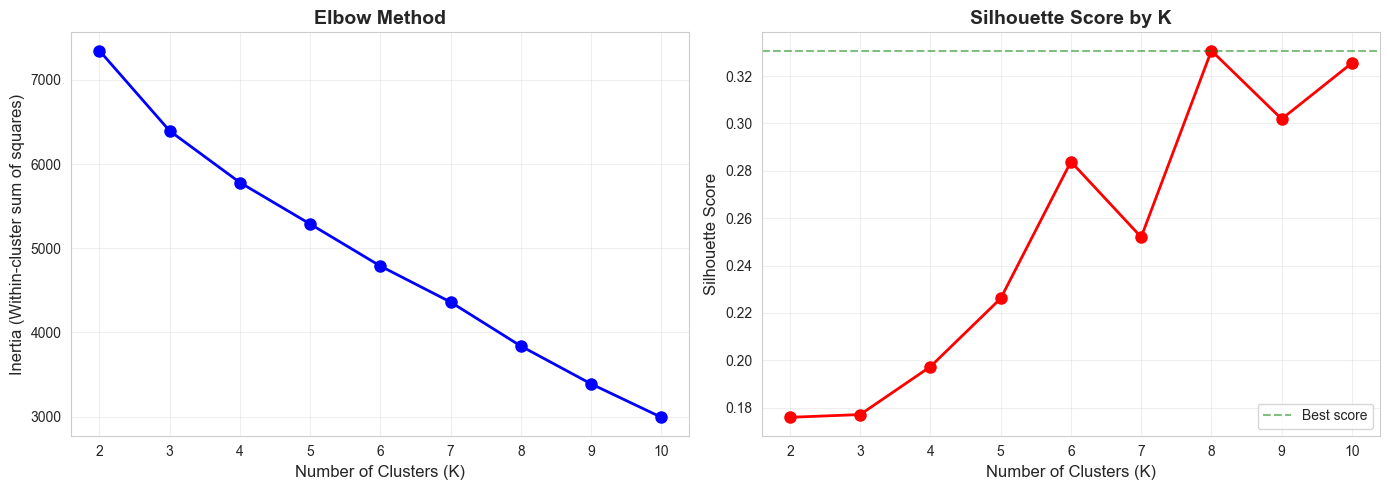


📊 Recommended K (highest silhouette): 8
   Silhouette score: 0.331


In [7]:
# Visualize elbow method and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(K_range)

# Silhouette plot
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score by K', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(K_range)
axes[1].axhline(y=max(silhouette_scores), color='green', linestyle='--', alpha=0.5, label='Best score')
axes[1].legend()

plt.tight_layout()
plt.show()

# Recommend optimal K
optimal_k_silhouette = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\n📊 Recommended K (highest silhouette): {optimal_k_silhouette}")
print(f"   Silhouette score: {max(silhouette_scores):.3f}")

In [8]:
# Choose optimal K (you can adjust based on elbow plot)
optimal_k = optimal_k_silhouette  # or choose manually
print(f"\nUsing K = {optimal_k} for final clustering")


Using K = 8 for final clustering


## 4. K-means Clustering

In [9]:
# Fit K-means with optimal K
print(f"Fitting K-means with K={optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster_KMeans'] = kmeans.fit_predict(X)

print(f"✓ K-means clustering complete")
print(f"\nCluster distribution:")
print(df['Cluster_KMeans'].value_counts().sort_index())

Fitting K-means with K=8...
✓ K-means clustering complete

Cluster distribution:
Cluster_KMeans
0    109
1    154
2     53
3     38
4     37
5     42
6     51
7     11
Name: count, dtype: int64


In [10]:
# Evaluate clustering quality
silhouette = silhouette_score(X, df['Cluster_KMeans'])
davies_bouldin = davies_bouldin_score(X, df['Cluster_KMeans'])
calinski_harabasz = calinski_harabasz_score(X, df['Cluster_KMeans'])

print("\nClustering Quality Metrics:")
print("="*60)
print(f"Silhouette Score: {silhouette:.3f} (higher is better, range: -1 to 1)")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f} (lower is better)")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f} (higher is better)")

if silhouette > 0.5:
    print("\n✅ Excellent clustering structure!")
elif silhouette > 0.3:
    print("\n✓ Good clustering structure")
else:
    print("\n⚠️ Clustering structure could be improved")


Clustering Quality Metrics:
Silhouette Score: 0.331 (higher is better, range: -1 to 1)
Davies-Bouldin Index: 1.167 (lower is better)
Calinski-Harabasz Index: 91.98 (higher is better)

✓ Good clustering structure


## 5. Cluster Characterization

Understand what each cluster represents

In [11]:
# Analyze cluster characteristics
print("\nCluster Characteristics:")
print("="*80)

cluster_stats = df.groupby('Cluster_KMeans')[clustering_features].mean()
cluster_stats


Cluster Characteristics:


,Num_Skills,Experience_Years,Experience_Level_Encoded,Education_Level_Encoded,Skill_Diversity,Technical_Skills_Count,Technical_Ratio,Has_Certification_Encoded,Has_Leadership_Encoded,Num_Skills_is_outlier,Num_Companies_is_outlier,Num_programming_languages,Num_web_technologies,Num_databases,Num_data_science,Num_cloud_devops,Num_mobile,Num_design,Num_soft_skills,Num_other_technical
Cluster_KMeans,,,,,,,,,,,,,,,,,,,,
0,0.413636,-0.000307,-0.011536,-0.004868,0.064656,0.767333,0.889860,-0.134441,0.008072,0.0,0.0,0.517101,-0.349212,-0.363405,1.780029,-0.414211,-0.289636,-0.310985,-0.150756,-0.738350
1,-0.936472,-0.074833,-0.074793,-0.059942,-0.700372,-1.218433,-1.357756,-0.070073,-0.094273,0.0,0.0,-0.750737,-0.355324,-0.546528,-0.502651,-0.430763,-0.289636,0.688610,-0.150756,0.417701
2,0.026887,0.132472,0.104171,0.210495,-0.761363,0.415804,0.815642,0.096020,0.071248,0.0,0.0,-0.765745,-0.355324,2.625001,-0.502651,-0.394551,-0.289636,-0.310985,-0.150756,-0.667258
3,0.316008,0.036865,0.033439,-0.130230,0.839844,-0.198866,-0.181145,-0.006454,0.075253,0.0,0.0,1.727964,-0.355324,-0.251698,-0.502651,0.031875,-0.289636,-0.310985,-0.150756,2.360226
4,0.928872,-0.065918,-0.141140,0.163768,-0.789921,1.092648,0.850754,-0.202170,0.046570,0.0,0.0,-0.765745,-0.355324,-0.556794,-0.502651,3.219942,-0.289636,-0.310985,-0.150756,-0.331013
5,-0.061199,-0.107221,-0.107999,-0.099609,1.489975,-0.182391,0.053866,0.105110,-0.063722,0.0,0.0,0.637509,-0.053933,0.070569,-0.502651,0.007007,3.123931,-0.310985,-0.150756,-0.536500
6,0.966220,0.048853,0.132954,0.011615,1.142463,1.151228,0.868832,0.411164,-0.010064,0.0,0.0,0.321899,2.832144,0.269849,-0.502651,0.232316,-0.289636,-0.310985,-0.150756,-0.424361
7,0.420167,0.689692,0.814654,0.098728,1.602775,-0.178326,-0.208772,0.245256,0.769897,0.0,0.0,1.755611,-0.355324,-0.173532,-0.502651,-0.008530,-0.289636,-0.310985,6.633250,1.659385


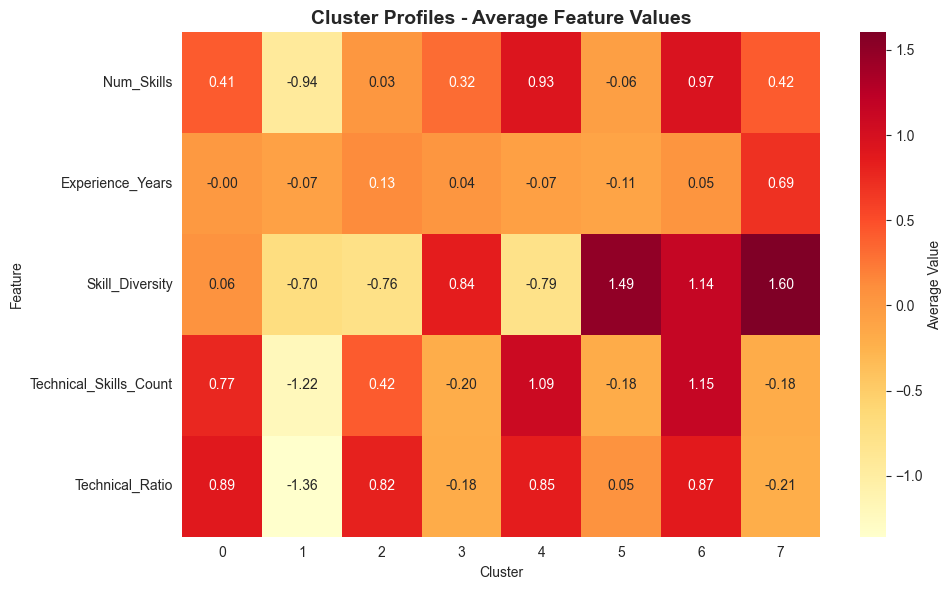

In [12]:
# Visualize cluster profiles
# Select key features for visualization
key_features = ['Num_Skills', 'Experience_Years', 'Skill_Diversity', 
                'Technical_Skills_Count', 'Technical_Ratio']
key_features = [f for f in key_features if f in clustering_features]

cluster_profiles = df.groupby('Cluster_KMeans')[key_features].mean()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Average Value'})
plt.title('Cluster Profiles - Average Feature Values', fontsize=14, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [13]:
# Add category distribution per cluster (if Category exists)
if 'Category' in df.columns:
    print("\nJob Category Distribution by Cluster:")
    print("="*60)
    
    for cluster in sorted(df['Cluster_KMeans'].unique()):
        print(f"\nCluster {cluster}:")
        cluster_categories = df[df['Cluster_KMeans'] == cluster]['Category'].value_counts()
        print(cluster_categories.head())
        print(f"  Total: {len(df[df['Cluster_KMeans'] == cluster])} resumes")


Job Category Distribution by Cluster:

Cluster 0:
Category
Machine Learning    61
Data Science        47
Web Development      1
Name: count, dtype: int64
  Total: 109 resumes

Cluster 1:
Category
Cybersecurity           54
Network Engineering     48
UI/UX Design            46
Software Engineering     6
Name: count, dtype: int64
  Total: 154 resumes

Cluster 2:
Category
Database Administration    53
Name: count, dtype: int64
  Total: 53 resumes

Cluster 3:
Category
Software Engineering    38
Name: count, dtype: int64
  Total: 38 resumes

Cluster 4:
Category
DevOps    37
Name: count, dtype: int64
  Total: 37 resumes

Cluster 5:
Category
Mobile Development    42
Name: count, dtype: int64
  Total: 42 resumes

Cluster 6:
Category
Web Development    51
Name: count, dtype: int64
  Total: 51 resumes

Cluster 7:
Category
Software Engineering    11
Name: count, dtype: int64
  Total: 11 resumes


In [14]:
# Name clusters based on characteristics
def name_cluster(cluster_id, cluster_data):
    """
    Give meaningful names to clusters based on their characteristics.
    """
    avg_exp = cluster_data['Experience_Years'].mean() if 'Experience_Years' in cluster_data.columns else 0
    avg_skills = cluster_data['Num_Skills'].mean() if 'Num_Skills' in cluster_data.columns else 0
    tech_ratio = cluster_data['Technical_Ratio'].mean() if 'Technical_Ratio' in cluster_data.columns else 0

    # Experience level
    if avg_exp < 2:
        exp_level = "Entry-Level"
    elif avg_exp < 5:
        exp_level = "Mid-Level"
    else:
        exp_level = "Senior"

    # Skill level
    if avg_skills < 10:
        skill_level = "Focused"
    else:
        skill_level = "Diverse"

    # Technical depth
    if tech_ratio > 0.7:
        specialization = "Technical Specialists"
    elif tech_ratio > 0.4:
        specialization = "Generalists"
    else:
        specialization = "Non-Technical"

    return f"{exp_level} {skill_level} {specialization}"

# Generate cluster names
cluster_names = {}
print("\nCluster Names:")
print("="*60)
for cluster_id in sorted(df['Cluster_KMeans'].unique()):
    cluster_data = df[df['Cluster_KMeans'] == cluster_id]
    name = name_cluster(cluster_id, cluster_data)
    cluster_id_native = int(cluster_id)  # ensure JSON-serializable keys
    cluster_names[cluster_id_native] = name
    print(f"Cluster {cluster_id_native}: {name}")

# Add cluster names to dataframe
df['Cluster_Name'] = df['Cluster_KMeans'].map(lambda label: cluster_names.get(int(label)))


Cluster Names:
Cluster 0: Entry-Level Focused Technical Specialists
Cluster 1: Entry-Level Focused Non-Technical
Cluster 2: Entry-Level Focused Technical Specialists
Cluster 3: Entry-Level Focused Non-Technical
Cluster 4: Entry-Level Focused Technical Specialists
Cluster 5: Entry-Level Focused Non-Technical
Cluster 6: Entry-Level Focused Technical Specialists
Cluster 7: Entry-Level Focused Non-Technical


## 6. Hierarchical Clustering (for comparison)

In [15]:
# Perform hierarchical clustering
print("Performing hierarchical clustering...")
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
df['Cluster_Hierarchical'] = hierarchical.fit_predict(X)

print(f"✓ Hierarchical clustering complete")
print(f"\nCluster distribution:")
print(df['Cluster_Hierarchical'].value_counts().sort_index())

Performing hierarchical clustering...
✓ Hierarchical clustering complete

Cluster distribution:
Cluster_Hierarchical
0     54
1    111
2     50
3    103
4     53
5     37
6     41
7     46
Name: count, dtype: int64


Creating dendrogram...


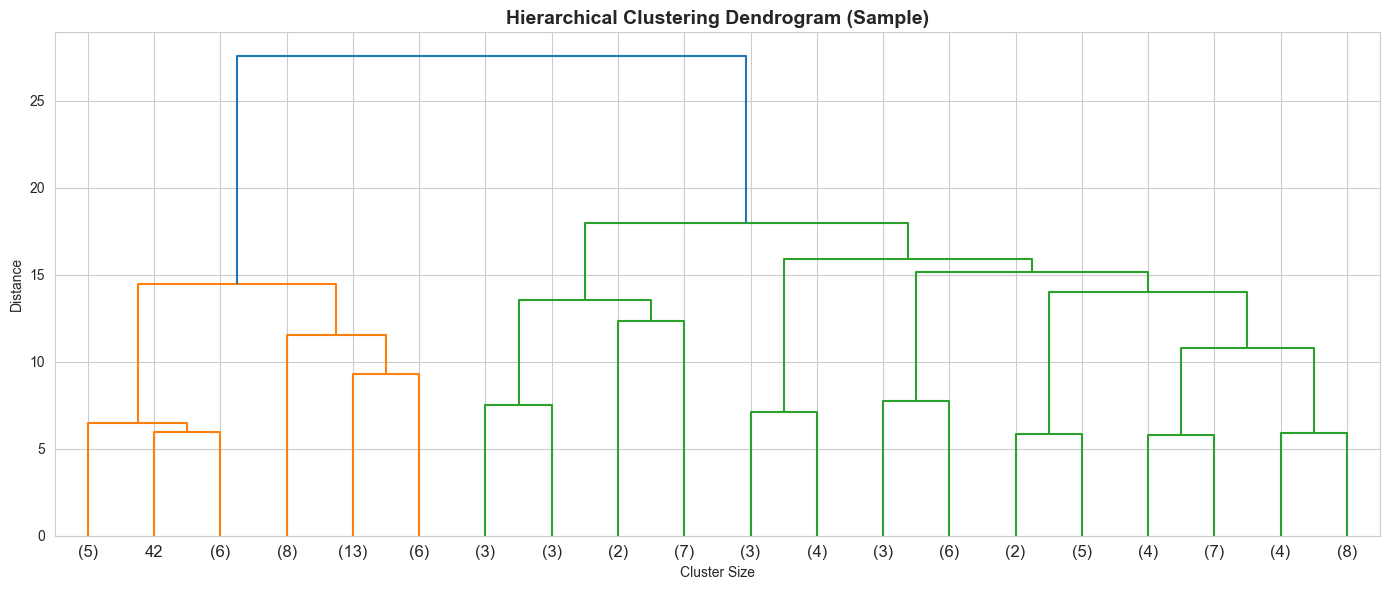

In [16]:
# Create dendrogram (sample data for visualization)
print("Creating dendrogram...")

# Use a sample for dendrogram (full dataset might be too large)
sample_size = min(100, len(X))
X_sample = X.sample(n=sample_size, random_state=42)

# Compute linkage
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20, show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram (Sample)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [17]:
# Compare K-means vs Hierarchical
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(df['Cluster_KMeans'], df['Cluster_Hierarchical'])
nmi = normalized_mutual_info_score(df['Cluster_KMeans'], df['Cluster_Hierarchical'])

print("\nComparison: K-means vs Hierarchical Clustering")
print("="*60)
print(f"Adjusted Rand Index: {ari:.3f} (1.0 = identical, 0 = random)")
print(f"Normalized Mutual Information: {nmi:.3f} (1.0 = identical)")

if ari > 0.7:
    print("\n✓ Both methods agree strongly on cluster structure")
elif ari > 0.4:
    print("\n✓ Both methods show moderate agreement")
else:
    print("\n⚠️ Methods disagree - clusters may not be very stable")


Comparison: K-means vs Hierarchical Clustering
Adjusted Rand Index: 0.810 (1.0 = identical, 0 = random)
Normalized Mutual Information: 0.907 (1.0 = identical)

✓ Both methods agree strongly on cluster structure


## 7. Dimensionality Reduction & Visualization

Visualize clusters in 2D using PCA and t-SNE

In [18]:
# PCA for 2D visualization
print("Applying PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

print(f"✓ PCA complete")
print(f"  Explained variance: {pca.explained_variance_ratio_.sum():.2%}")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}")

Applying PCA...
✓ PCA complete
  Explained variance: 39.49%
  PC1: 24.68%
  PC2: 14.81%


In [19]:
# t-SNE for 2D visualization (better for non-linear relationships)
print("\nApplying t-SNE (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

df['TSNE1'] = X_tsne[:, 0]
df['TSNE2'] = X_tsne[:, 1]

print("✓ t-SNE complete")


Applying t-SNE (this may take a minute)...
✓ t-SNE complete


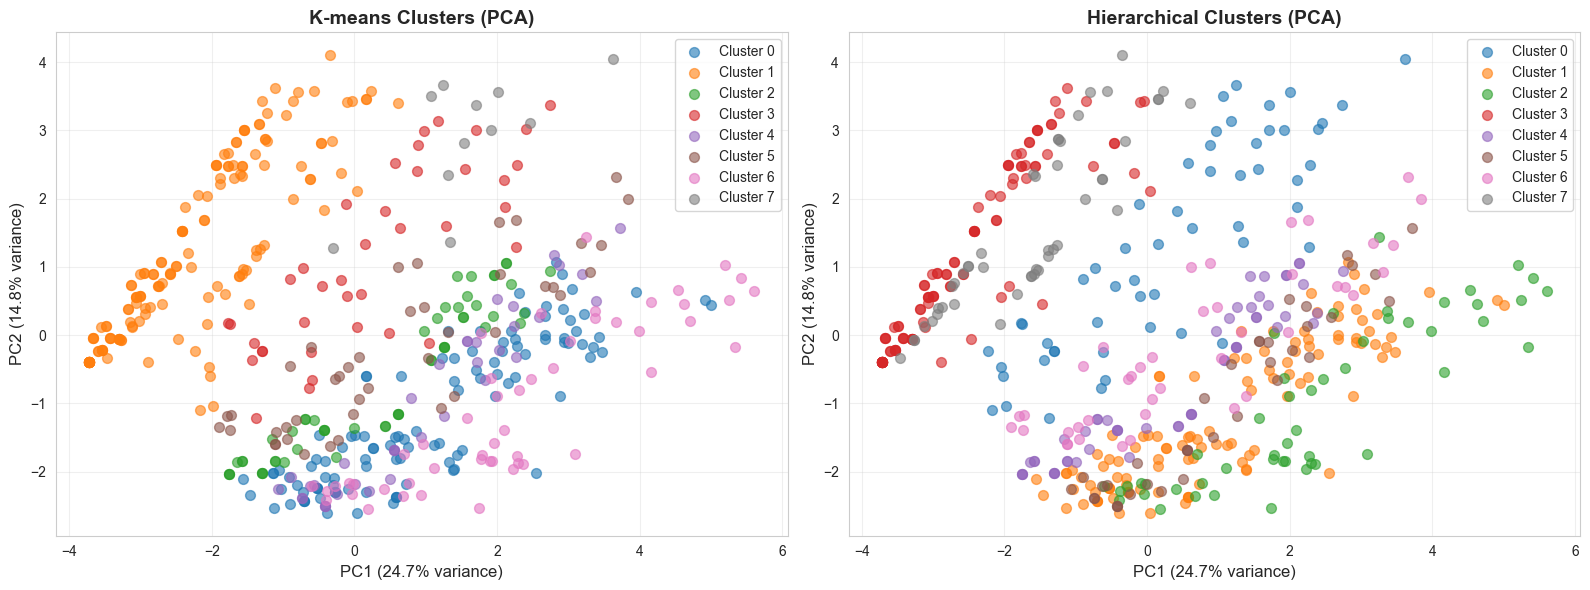

In [20]:
# Visualize clusters with PCA
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-means clusters
for cluster in sorted(df['Cluster_KMeans'].unique()):
    cluster_data = df[df['Cluster_KMeans'] == cluster]
    axes[0].scatter(cluster_data['PCA1'], cluster_data['PCA2'], 
                   label=f'Cluster {cluster}', alpha=0.6, s=50)

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[0].set_title('K-means Clusters (PCA)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Hierarchical clusters
for cluster in sorted(df['Cluster_Hierarchical'].unique()):
    cluster_data = df[df['Cluster_Hierarchical'] == cluster]
    axes[1].scatter(cluster_data['PCA1'], cluster_data['PCA2'], 
                   label=f'Cluster {cluster}', alpha=0.6, s=50)

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[1].set_title('Hierarchical Clusters (PCA)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

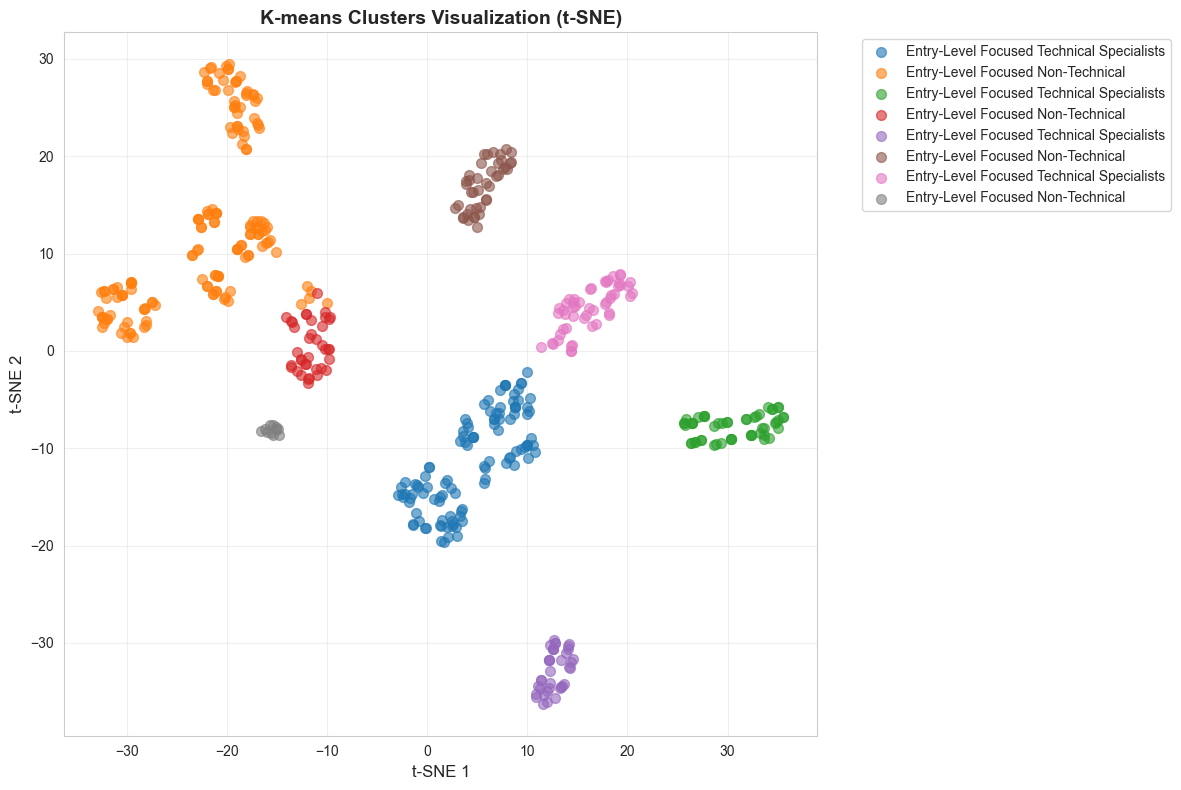

In [21]:
# Visualize clusters with t-SNE
plt.figure(figsize=(12, 8))

for cluster in sorted(df['Cluster_KMeans'].unique()):
    cluster_data = df[df['Cluster_KMeans'] == cluster]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], 
               label=cluster_names.get(cluster, f'Cluster {cluster}'), 
               alpha=0.6, s=50)

plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.title('K-means Clusters Visualization (t-SNE)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Save Models and Results

In [22]:
# Save clustering models
joblib.dump(kmeans, '../models/kmeans_model.pkl')
joblib.dump(pca, '../models/pca_model.pkl')
print("✓ Models saved")

# Save cluster names
with open('../models/cluster_names.json', 'w') as f:
    json.dump(cluster_names, f, indent=2)
print("✓ Cluster names saved")

# Save clustering features list
with open('../models/clustering_features.json', 'w') as f:
    json.dump(clustering_features, f, indent=2)
print("✓ Clustering features saved")

✓ Models saved
✓ Cluster names saved
✓ Clustering features saved


In [23]:
# Save data with cluster assignments
output_path = '../data/processed/resumes_clustered.csv'
df.to_csv(output_path, index=False)
print(f"\n✓ Data with clusters saved: {output_path}")
print(f"  Shape: {df.shape}")


✓ Data with clusters saved: ../data/processed/resumes_clustered.csv
  Shape: (495, 62)


## 9. Clustering Summary

In [24]:
print("\n" + "="*80)
print("CLUSTERING ANALYSIS COMPLETE")
print("="*80)
print(f"\n📊 Summary:")
print(f"  Optimal K: {optimal_k}")
print(f"  Silhouette Score: {silhouette:.3f}")
print(f"  Davies-Bouldin Index: {davies_bouldin:.3f}")
print(f"  Calinski-Harabasz Index: {calinski_harabasz:.2f}")

print(f"\n🏷️ Clusters Identified:")
for cluster_id, name in cluster_names.items():
    count = len(df[df['Cluster_KMeans'] == cluster_id])
    percentage = (count / len(df)) * 100
    print(f"  Cluster {cluster_id}: {name}")
    print(f"    - Size: {count} resumes ({percentage:.1f}%)")

print(f"\n✅ Next step: Scoring & Percentile Ranking (Notebook 05)")


CLUSTERING ANALYSIS COMPLETE

📊 Summary:
  Optimal K: 8
  Silhouette Score: 0.331
  Davies-Bouldin Index: 1.167
  Calinski-Harabasz Index: 91.98

🏷️ Clusters Identified:
  Cluster 0: Entry-Level Focused Technical Specialists
    - Size: 109 resumes (22.0%)
  Cluster 1: Entry-Level Focused Non-Technical
    - Size: 154 resumes (31.1%)
  Cluster 2: Entry-Level Focused Technical Specialists
    - Size: 53 resumes (10.7%)
  Cluster 3: Entry-Level Focused Non-Technical
    - Size: 38 resumes (7.7%)
  Cluster 4: Entry-Level Focused Technical Specialists
    - Size: 37 resumes (7.5%)
  Cluster 5: Entry-Level Focused Non-Technical
    - Size: 42 resumes (8.5%)
  Cluster 6: Entry-Level Focused Technical Specialists
    - Size: 51 resumes (10.3%)
  Cluster 7: Entry-Level Focused Non-Technical
    - Size: 11 resumes (2.2%)

✅ Next step: Scoring & Percentile Ranking (Notebook 05)
